# Assignment Digital Signal & Image Processing
Giulia Benvenuto s4678610

## Kalman filtering
Hand in a Python notebook which implements a Kalman filter for the estimation of a function $f$ and its first derivative $f'$
in the interval $[0, 10]$ from $1000$ equally spaced noisy samples.


Define $f:[0,1] \rightarrow \mathbb{R}$ as:

<center>
$
\begin{equation}
f(t) = sin(pt)e^{qt}
\end{equation}
$ 
</center>
<br>

With $p$ and $q$ sampled uniformly in the interval $[2, 4]$. For $i = 0,1,...,999$ let $t_i = i/1000$ and: 
<center>
$
\begin{equation}
f_i = f(t_i) + \epsilon_i
\end{equation}
$ 
</center>
<br>

with $\epsilon_i$ sampled from a Gaussian distribution with $\mu = 0$ and $\sigma = 0.1$ and $\sigma = 0.5$.

Plot the estimates against the values for $f$ and $f'$ computed analytically in the two cases. Study how the
filtered estimates change for increasing values of the noise process covariance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = (12, 8)

In [2]:
p = np.random.uniform(2, np.nextafter(4, 5))
q = np.random.uniform(2, np.nextafter(4, 5))
print("p:" ,p)
print("q:" ,q)

p: 2.571404617323868
q: 3.9803817591315074


### Sampling the time

In [3]:
ti = np.zeros(1000)
i = np.arange(0, 1000)
ti = i / 1000

n = len(ti)
print("Samples in time:" ,n)

delta_t = ti[1] - ti[0]
print("Sampling rate:" ,delta_t)

Samples in time: 1000
Sampling rate: 0.001


## Functions
Define $f:[0,1] \rightarrow \mathbb{R}$ as:
<center>
    $f(t) = \sin (pt) e^{qt}$     
<\center>

I computed the derivative $f'$ using the *Product Rule* which states that the derivative of a product of two functions is the first function times the derivative of the second function plus the second function times the derivative of the first function.
<center> 
    $(h(t) g(t))' = h'(t) g(t) + h(t) g'(t)$
    <br>
    So I get:
    <br>
    $f'(t) = q \sin(pt) e^{qt} + p \cos(pt) e^{qt} = e^{qt} (q \sin(pt) + p \cos(pt))$
<\center>

## Analytical evaluation f(t) and f'(t)
$f(t)$ and $f'(t)$ computed analitically in the sampled values of the time.

In [4]:
# Compute the values for f analytically:
f = np.sin(p * ti) * np.exp(q * ti)

# Compute the values for f analytically:
f_dt = ((p * np.cos(p * ti)) * (np.exp(q * ti))) + ((q * np.sin(p * ti)) * (np.exp(q * ti)))

## Measurement models for f(t) and f'(t)
Our measurement model is:
<center>
    $f_i = f(t_i) + \epsilon_i$
<\center>

This means that the values $f_i$ are our measurements affected by Gaussian noise $\epsilon_i$ with $\mu = 0$ and $\sigma = 0.1$ or $\sigma = 0.5$.
    
These measurements will be used from the Kalman Filter to produce an estimate of the state of the system as an average of the system's predicted state and of the new measurement using a wighted average.

In [5]:
mu = 0
np.random.seed(9999)
        
def measurements_f(t, sigma):
    m_f = np.zeros(len(t))
    epsilon = np.random.normal(mu, sigma, len(t))
    
    for i in range(0, 1000):
        m_f[i] = (np.sin(p * t[i]) * np.exp(q * t[i])) + epsilon[i]
        
    return m_f

## Kalman filter
A Kalman filter is a mathematical algorithm that uses a series of measurements and predictions to estimate the state of a system, taking into account that future samples are often correlated with the current sample. 

The filter uses a process model that describes how the system behaves over time, and a measurement model that describes how the system is observed.

The function below implements the Kalman Filter as following:
- Acquire the measurements $m_k$ computed with the measurement model above
- Set the Kalman gain estimated as: $K_k = P_k^- H^T (H P_k^- H^T + R)^{-1}$
- Update step which consists in:

    An update of the state of the system after the acquisition of a new measure: 
    $\hat{s}_{k}=\hat{s}_{k}^-+K_{k}\big(m_{k}-H\hat{s}_{k}^-\big)$
    
    An update of the error covariance matrix after the acquisition of a new 
    measure: $P_{k}=(I-K_{k}H)P^-_{k}$
- Projection / prediction step which consists in:
    
    A prediction of the state update at the time $k+1$ before taking a new 
    measure: $\hat{s}^{-}_{k+1} = \Phi\hat{s}_k$
    
    A prediction of the error covariance matrix update at the time $k+1$ before
    taking a new measure: $P^{-}_{k+1} = \Phi P_k\Phi^T + Q$

In [6]:
def naive_KF(m, P_pred, s_pred, Phi, H, Q, R):
    """Naive Kalman Filter implementation.
    
    Inputs:
    - m (M-dim float) the new measurement
    - P_pred (NxN-dim float array) error covariaance prediction
    - s_pred (N-dim float array) state prediction
    - Phi (float array) state transition matrix
    - H (MxN-dim float array) measurement matrix  
    - Q (NxN-dim float array) process noise covariance
    - R (MxM-dim float) measurement noise variance
    """
    N = len(s_pred);
    
    # Kalman gain

    K = np.dot(P_pred, H.T) * float((np.dot(np.dot(H, P_pred),H.T) + R)) ** -1
    K = K[:,None] ## add newaxis 
         
    # Update
    _reserr  = m - np.dot(H, s_pred)
    s = s_pred + (K * _reserr)
    
    IKH = np.eye(N) - np.dot(K,H[:,None].T)
    P = np.dot(IKH, P_pred)
    
    # Prediction
    s_pred = np.dot(Phi, s)
    P_pred = np.dot(np.dot(Phi, P), Phi.T) 
   
    P_pred = P_pred + Q
    
    return P_pred, s_pred

## Case 1 - $\sigma = 0.1$
$f_i = f(t_i) + \epsilon_i$

In [7]:
sigma_1 = 0.1

In [8]:
# Compute the measurements:
m_f = measurements_f(ti, sigma_1)

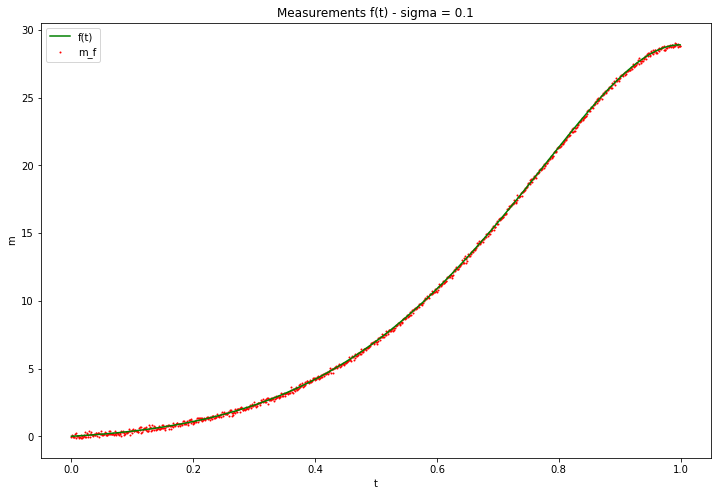

In [9]:
plt.scatter(ti, m_f, s = 4, color = 'r', marker = '.', label = 'm_f')
plt.plot(ti, f, color = 'g', label = 'f(t)')
plt.title("Measurements f(t) - sigma = 0.1")
plt.xlabel("t")
plt.ylabel("m")
plt.legend()
plt.show()

The plot shows both the measurements taken by the measurement model, as we can see with $\sigma = 0.1$ the noise is little, all the measurements are close to the analytical function. The measurement variance $R = \sigma = 0.1$ represents the uncertainty in the measurements, and is used as a weighting factor in the filter's estimation process.
If the measurement variance is small, it means that the measurements are very reliable and the filter will give more weight to the measurements in its estimation of the state. 

In [10]:
# Initialization
s_pred = np.ones([2,1])
P_pred = np.ones([2,2])

Phi = np.array([[1, 1/1000],[0, 1]]) # state transition matrix
H = np.array([1,0]) # observation matrix
Q = np.array([[1e-6, 0],[0, 5]]) # process noise covariance
R = sigma_1 # measurement variance

# Simulate real-time data acquisition
func = np.zeros(n) 
der = np.zeros(n)

In [11]:
# Kalman Filter over the measurements:
for i, m_new in enumerate(m_f):
    # run Kalman Filtering
    P_pred_new, s_pred_new = naive_KF(m_new, P_pred, s_pred, Phi, H, Q, R)
    
    func[i] = s_pred_new[0]
    der[i] = s_pred_new[1]
    #print(der[i])
    #
    # Update status and covariance
    s_pred = s_pred_new.copy()
    P_pred = P_pred_new.copy()

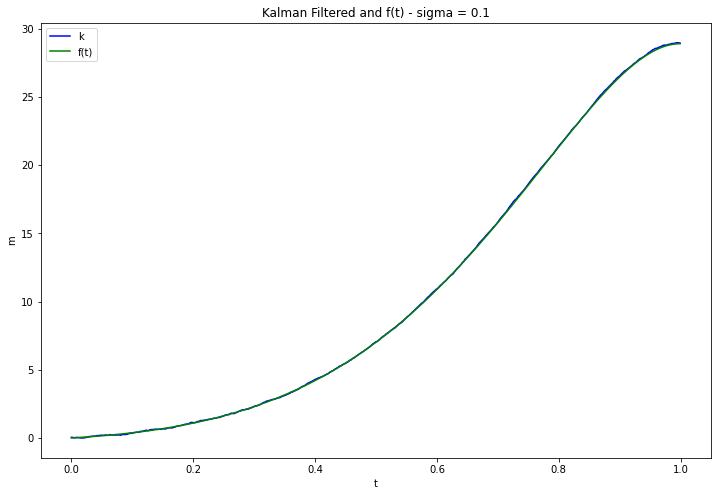

In [12]:
plt.plot(ti, func, color = 'b', label = 'k')
plt.plot(ti, f, color = 'g', label = 'f(t)')
plt.title("Kalman Filtered and f(t) - sigma = 0.1")
plt.xlabel("t")
plt.ylabel("m")
plt.legend()
plt.show()

The filter is able to track the signal closely because the measurement noise is small. But the precision of the estimated function is also due to the process noise covariance $Q$ initialization. 

The process noise covariance matrix represents the uncertainty in the process model. 
If the values of the process noise covariance are small, it means that the uncertainty in the process model is lower, and the filter will be more certain about the state of the system. In this case, the filter will give more weight to the process model in its estimation of the state, since the process model is more reliable.

If we try to increase the process noise covariance the estimation of the Kalman filter will be less precise and smooth:

In [19]:
# Initialization
s_pred = np.ones([2,1])
P_pred = np.ones([2,2])

Phi = np.array([[1, 1/1000],[0, 1]]) # state transition matrix
H = np.array([1,0]) # observation matrix
Q = np.array([[1, 0],[0, 5]]) # process noise covariance
R = sigma_1 # measurement variance

# Simulate real-time data acquisition
func = np.zeros(n) 
der = np.zeros(n)

In [20]:
for i, m_new in enumerate(m_f):
    # run Kalman Filtering
    P_pred_new, s_pred_new = naive_KF(m_new, P_pred, s_pred, Phi, H, Q, R)
    
    func[i] = s_pred_new[0]
    der[i] = s_pred_new[1]
    #print(der[i])
    #
    # Update status and covariance
    s_pred = s_pred_new.copy()
    P_pred = P_pred_new.copy()

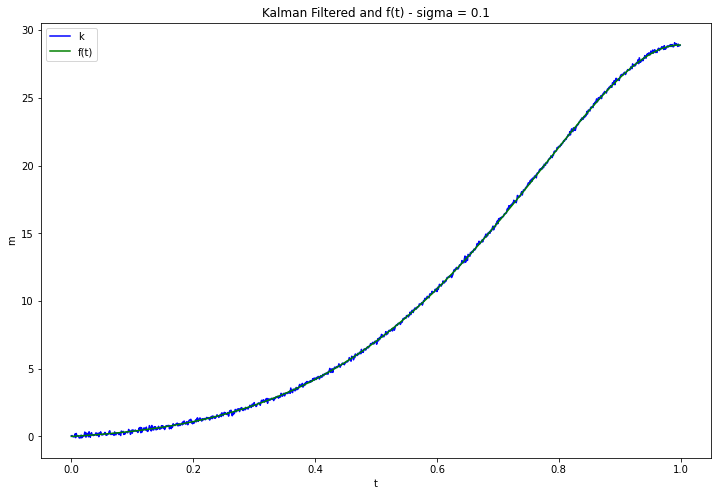

In [21]:
plt.plot(ti, func, color = 'b', label = 'k')
plt.plot(ti, f, color = 'g', label = 'f(t)')
plt.title("Kalman Filtered and f(t) - sigma = 0.1")
plt.xlabel("t")
plt.ylabel("m")
plt.legend()
plt.show()

### Derivative

In [22]:
# Initialization
s_pred = np.ones([2,1])
P_pred = np.ones([2,2])

Phi = np.array([[1, 1/1000],[0, 1]]) # state transition matrix
H = np.array([1,0]) # observation matrix
Q = np.array([[1e-6, 0],[0, 5]]) # process noise covariance
R = sigma_1 # measurement variance

# Simulate real-time data acquisition
func = np.zeros(n) 
der = np.zeros(n)

In [23]:
# Kalman Filter over the measurements:
for i, m_new in enumerate(m_f):
    # run Kalman Filtering
    P_pred_new, s_pred_new = naive_KF(m_new, P_pred, s_pred, Phi, H, Q, R)
    
    func[i] = s_pred_new[0]
    der[i] = s_pred_new[1]
    #print(der[i])
    #
    # Update status and covariance
    s_pred = s_pred_new.copy()
    P_pred = P_pred_new.copy()

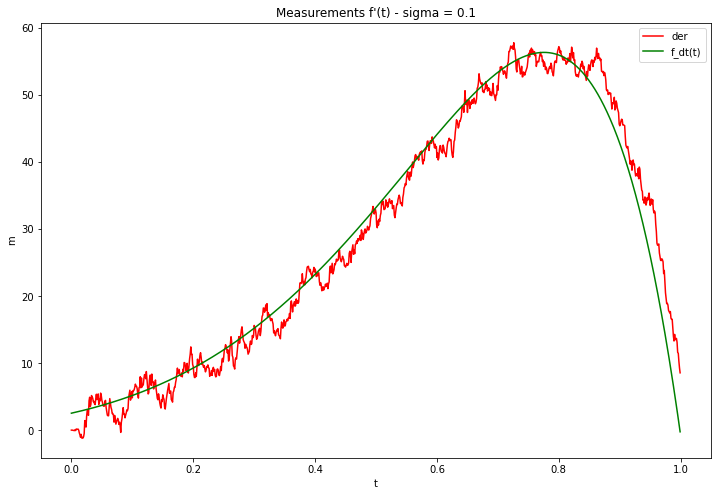

In [24]:
plt.plot(ti, der, color = 'r', label = 'der')
plt.plot(ti, f_dt, color = 'g', label = 'f_dt(t)')
plt.title("Measurements f'(t) - sigma = 0.1")
plt.xlabel("t")
plt.ylabel("m")
plt.legend()
plt.show()

## Case 2 - $\sigma = 0.5$
$f_i = f(t_i) + \epsilon_i$

In [25]:
sigma_2 = 0.5

In [26]:
# Compute the measurements:
m_f = measurements_f(ti, sigma_2)

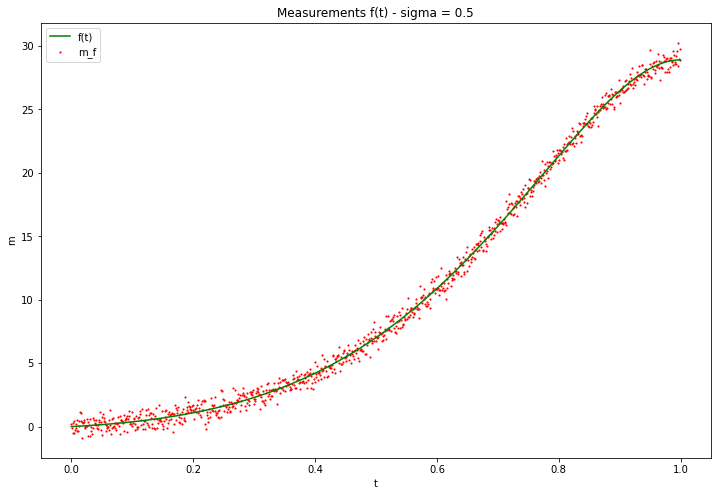

In [27]:
plt.scatter(ti, m_f, s = 5, color = 'r', marker = '.', label = 'm_f')
plt.plot(ti, f, color = 'g', label = 'f(t)')
plt.title("Measurements f(t) - sigma = 0.5")
plt.xlabel("t")
plt.ylabel("m")
plt.legend()
plt.show()

The plot shows both the measurements taken by the measurement model, as we can see with $\sigma = 0.5$ the noise is bigger than the previous case, all the measurements are are further away respect to the analytical function. The measurement variance $R = \sigma = 0.5$ represents the uncertainty in the measurements, and is used as a weighting factor in the filter's estimation process.

If the measurement variance is large, as in this case, it means that the uncertainty or error in the measurements is high. In a Kalman filter, this would lead to a lower weighting of the measurements in the state estimation, and a higher weighting of the model predictions. Essentially, the filter would place more trust in the model's predictions and less trust in the measurements. This can result in a less accurate estimate of the true state of the system being tracked.

In [28]:
# Initialization
s_pred = np.ones([2,1])
P_pred = np.ones([2,2])

Phi = np.array([[1, 1/1000],[0, 1]]) # state transition matrix
H = np.array([1,0]) # observation matrix
Q = np.array([[1e-6, 0],[0, 5]]) # process noise covariance
R = sigma_2 # measurement variance

# Simulate real-time data acquisition
func = np.zeros(n) 
der = np.zeros(n)

In [29]:
for i, m_new in enumerate(m_f):
    # run Kalman Filtering
    P_pred_new, s_pred_new = naive_KF(m_new, P_pred, s_pred, Phi, H, Q, R)
    
    func[i] = s_pred_new[0]
    der[i] = s_pred_new[1]
    #
    # Update status and covariance
    s_pred = s_pred_new.copy()
    P_pred = P_pred_new.copy()

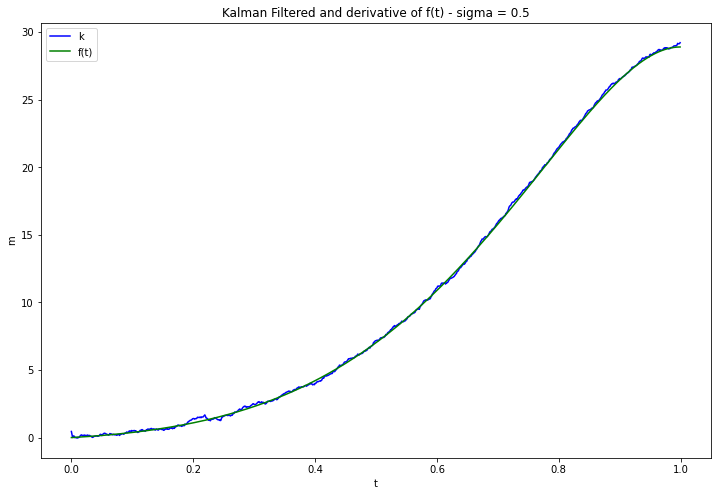

In [30]:
plt.plot(ti, func, color = 'b', label = 'k')
plt.plot(ti, f, color = 'g', label = 'f(t)')
plt.title("Kalman Filtered and derivative of f(t) - sigma = 0.5")
plt.xlabel("t")
plt.ylabel("m")
plt.legend()
plt.show()

As we expect the result is less precise and smooth respect to the previous case.

And as before, if now we increase the process noise covariance $Q$, the result will be less and less precise:

In [31]:
# Initialization
s_pred = np.ones([2,1])
P_pred = np.ones([2,2])

Phi = np.array([[1, 1/1000],[0, 1]]) # state transition matrix
H = np.array([1,0]) # observation matrix
Q = np.array([[1, 0],[0, 5]]) # process noise covariance
R = sigma_2 # measurement variance

# Simulate real-time data acquisition
func = np.zeros(n) 
der = np.zeros(n)

In [32]:
for i, m_new in enumerate(m_f):
    # run Kalman Filtering
    P_pred_new, s_pred_new = naive_KF(m_new, P_pred, s_pred, Phi, H, Q, R)
    
    func[i] = s_pred_new[0]
    der[i] = s_pred_new[1]
    #
    # Update status and covariance
    s_pred = s_pred_new.copy()
    P_pred = P_pred_new.copy()

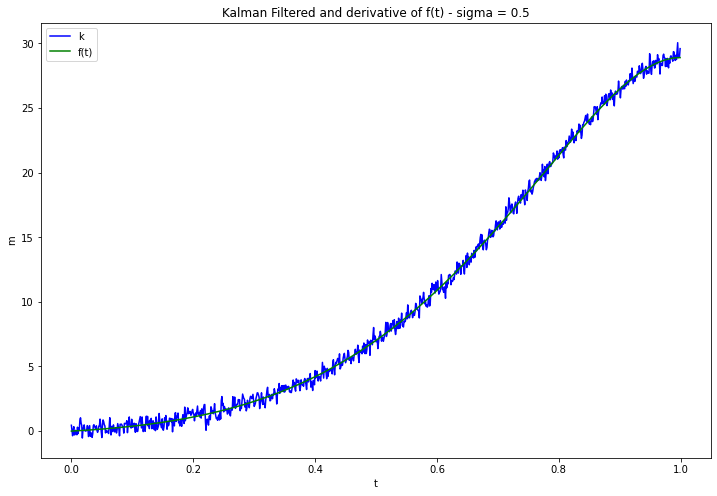

In [33]:
plt.plot(ti, func, color = 'b', label = 'k')
plt.plot(ti, f, color = 'g', label = 'f(t)')
plt.title("Kalman Filtered and derivative of f(t) - sigma = 0.5")
plt.xlabel("t")
plt.ylabel("m")
plt.legend()
plt.show()

### Derivative

In [34]:
# Initialization
s_pred = np.ones([2,1])
P_pred = np.ones([2,2])

Phi = np.array([[1, 1/1000],[0, 1]]) # state transition matrix
H = np.array([1,0]) # observation matrix
Q = np.array([[1e-6, 0],[0, 5]]) # process noise covariance
R = sigma_2 # measurement variance

# Simulate real-time data acquisition
func = np.zeros(n) 
der = np.zeros(n)

In [35]:
for i, m_new in enumerate(m_f):
    # run Kalman Filtering
    P_pred_new, s_pred_new = naive_KF(m_new, P_pred, s_pred, Phi, H, Q, R)
    
    func[i] = s_pred_new[0]
    der[i] = s_pred_new[1]
    #
    # Update status and covariance
    s_pred = s_pred_new.copy()
    P_pred = P_pred_new.copy()

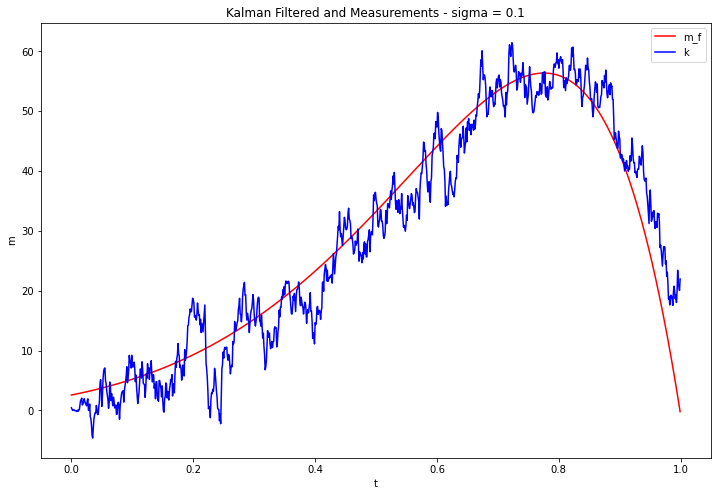

In [36]:
plt.plot(ti, f_dt, color = 'r', label = 'm_f')
plt.plot(ti, der, color = 'b',  label = 'k')
plt.title("Kalman Filtered and Measurements - sigma = 0.1")
plt.xlabel("t")
plt.ylabel("m")
plt.legend()
plt.show()